In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

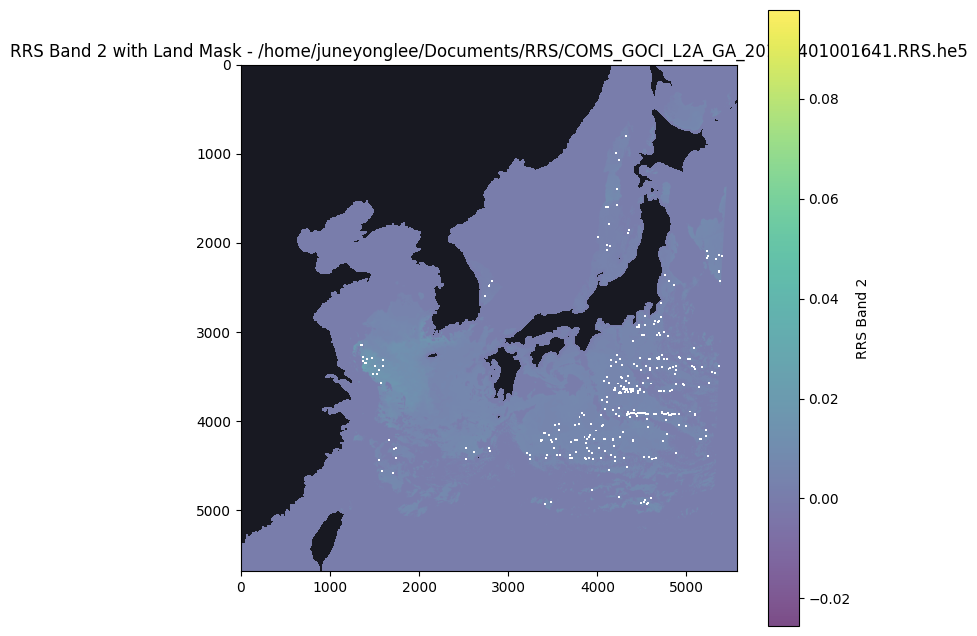

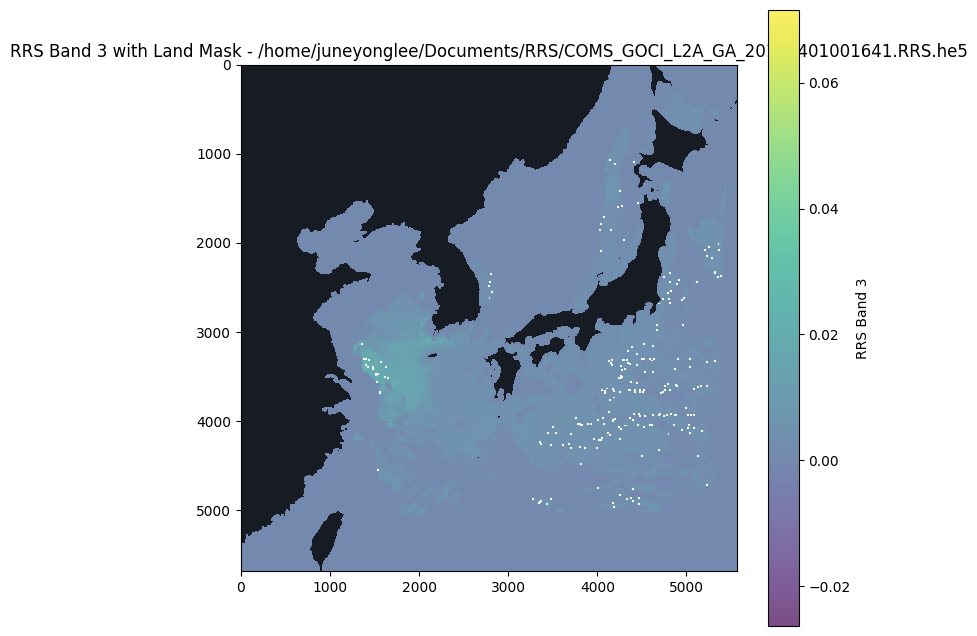

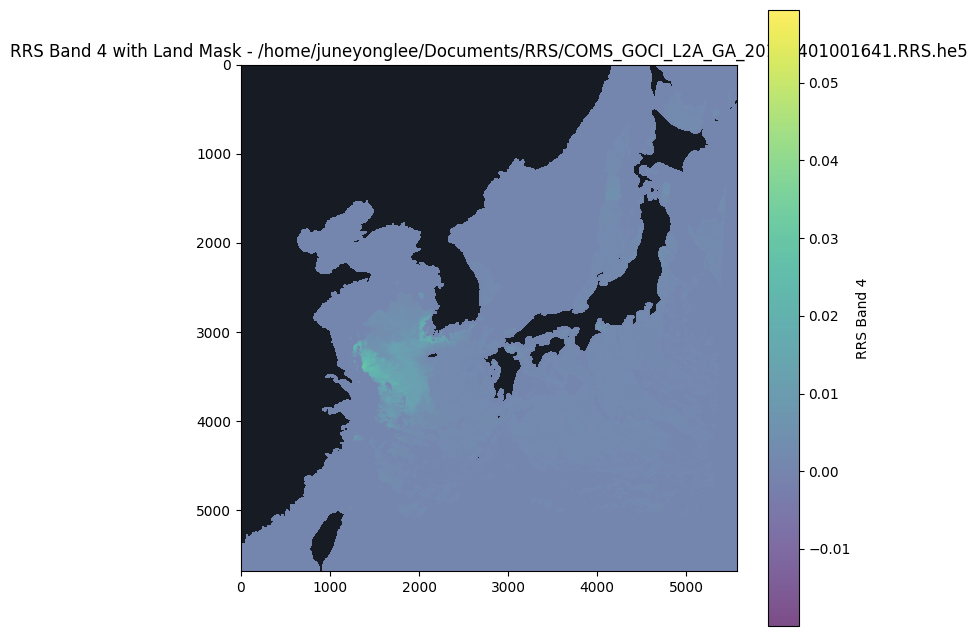

In [26]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'
land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# 특정 범위의 좌표 설정 (필요에 따라 지정할 수 있습니다. 여기서는 전체 범위를 사용)
# 범위를 설정하지 않으면 데이터 전체를 사용합니다.
y_min, y_max = 0, None
x_min, x_max = 0, None

def display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min=None, y_max=None, x_min=None, x_max=None):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 지정된 좌표 범위 내 데이터만 선택
        np_rrs = np_rrs[y_min:y_max, x_min:x_max]

        # 육지 마스크도 동일한 범위로 자르기
        land_mask_cropped = land_mask[y_min:y_max, x_min:x_max]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(8, 8))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=0.7)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        plt.title(f'RRS Band {band} with Land Mask - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크 함께 시각화
display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min, y_max, x_min, x_max)


Band 2 unique values: [-9.9900000e+02 -2.5540330e-02 -2.3389757e-02 ...  5.0626244e-02
  9.7815126e-02            nan]
Band 2 data type: float32
Band 2 has data type: float32


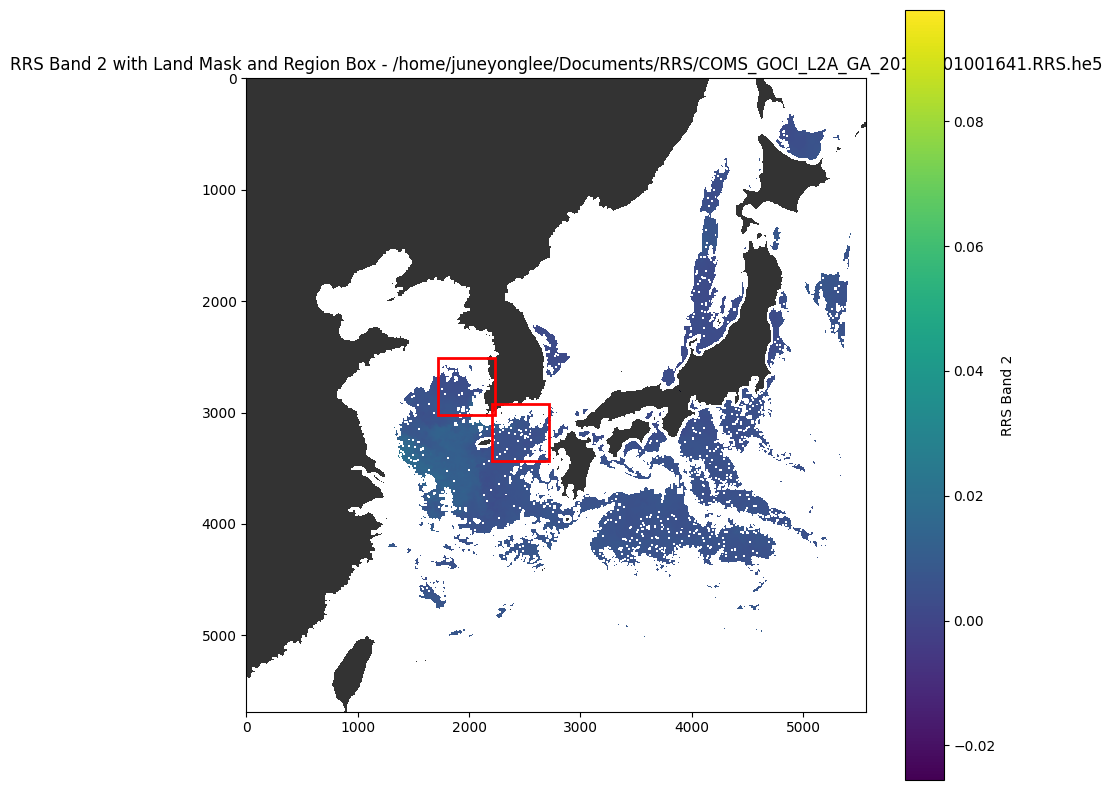

Band 3 unique values: [-9.9900000e+02 -2.6318939e-02 -2.5868699e-02 ...  4.9201962e-02
  7.1533538e-02            nan]
Band 3 data type: float32
Band 3 has data type: float32


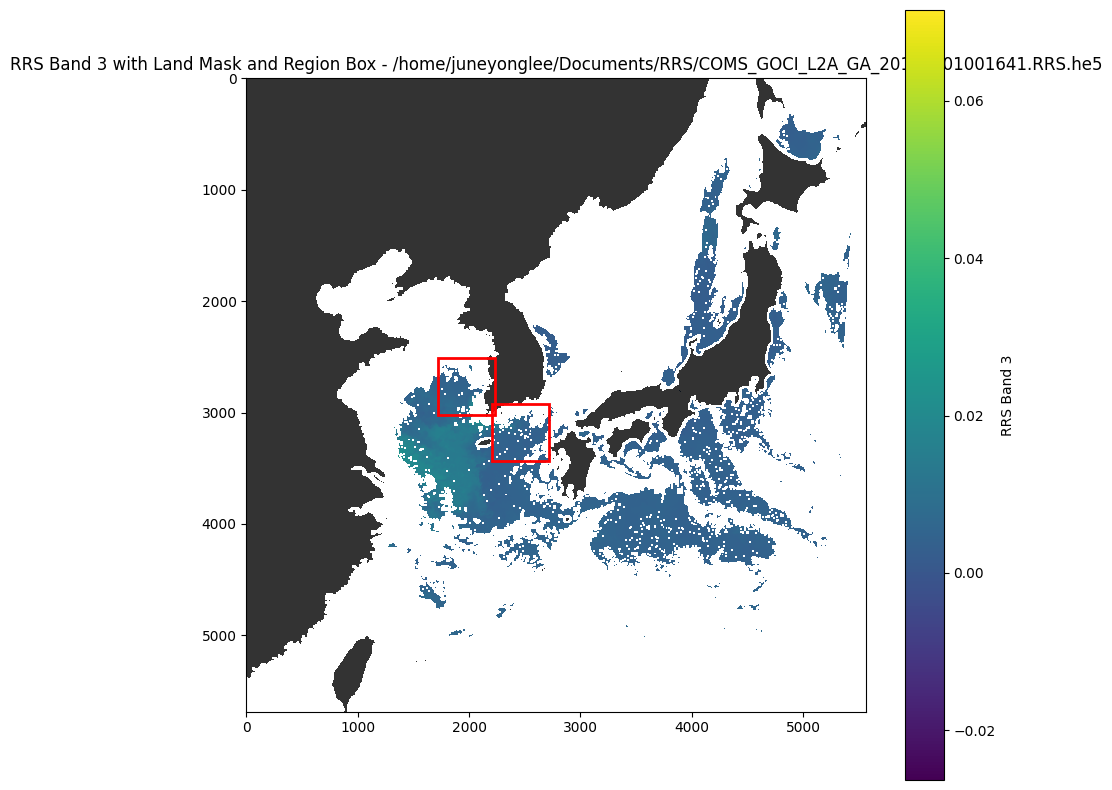

Band 4 unique values: [-9.9900000e+02 -1.9909916e-02 -1.9639613e-02 ...  3.6565781e-02
  3.7591778e-02  5.9344467e-02]
Band 4 data type: float32
Band 4 has data type: float32


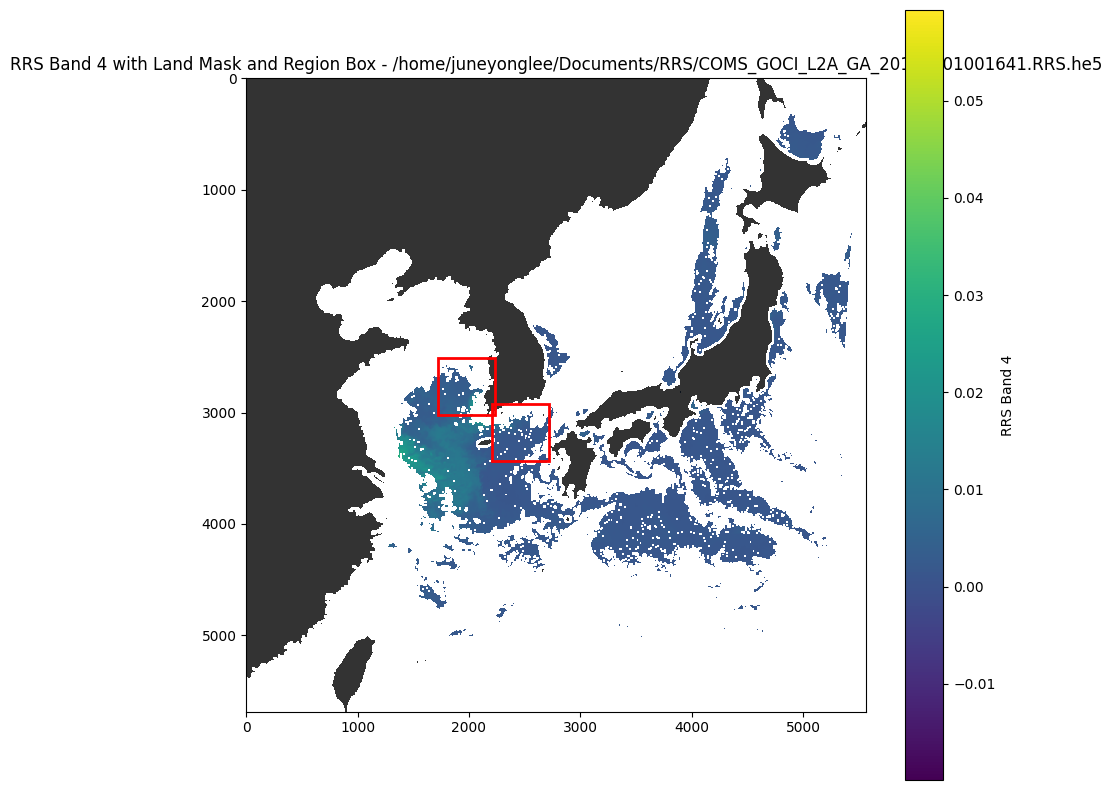

In [13]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'

land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# Define the patch size and region coordinates
patch_size = 512

# # 낙동강 좌표 설정 (픽셀 좌표, 중간좌표 기준)
# region1_x_min, region1_x_max = 2336, 2592
# region1_y_min, region1_y_max = 3053, 3309
# # 새만금 좌표 설정 (픽셀 좌표, 중간좌표 기준)
# region2_x_min, region2_x_max = 1851, 2107
# region2_y_min, region2_y_max = 2639, 2895

# Nakdong coordinates
region1_center_x, region1_center_y = (2336 + 2592) // 2, (3053 + 3309) // 2
# Saemangeum coordinates
region2_center_x, region2_center_y = (1851 + 2107) // 2, (2639 + 2895) // 2

# Calculate the top-left coordinates for the 512x512 patches
region1_x_min, region1_y_min = region1_center_x - patch_size // 2, region1_center_y - patch_size // 2
region1_x_max, region1_y_max = region1_center_x + patch_size // 2, region1_center_y + patch_size // 2

region2_x_min, region2_y_min = region2_center_x - patch_size // 2, region2_center_y - patch_size // 2
region2_x_max, region2_y_max = region2_center_x + patch_size // 2, region2_center_y + patch_size // 2

def display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region1_x_min, region1_x_max, region1_y_min, region1_y_max, region2_x_min, region2_x_max, region2_y_min, region2_y_max):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 고유값 출력
        unique_values = np.unique(np_rrs)
        print(f"Band {band} unique values: {unique_values}")

        # 데이터 유형 확인 (8비트 또는 16비트)
        data_type = np_rrs.dtype
        print(f"Band {band} data type: {data_type}")
        
        # 데이터가 8비트인지 16비트인지 확인
        if data_type == np.uint8:
            print(f"Band {band} is 8-bit data.")
        elif data_type == np.uint16:
            print(f"Band {band} is 16-bit data.")
        else:
            print(f"Band {band} has data type: {data_type}")

        # 육지 마스크 크기 맞추기 (전체 범위로)
        land_mask_cropped = land_mask[:np_rrs.shape[0], :np_rrs.shape[1]]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(10, 10))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=1)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        # 낙동강 좌표 범위에 빨간색 사각형 추가
        rect1 = Rectangle((region1_x_min, region1_y_min), region1_x_max - region1_x_min, region1_y_max - region1_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect1)

        # 새만금 좌표 범위에 빨간색 사각형 추가
        rect2 = Rectangle((region2_x_min, region2_y_min), region2_x_max - region2_x_min, region2_y_max - region2_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect2)

        plt.title(f'RRS Band {band} with Land Mask and Region Box - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크, 새만금 및 낙동강 좌표 범위에 네모 박스 표시
display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region1_x_min, region1_x_max, region1_y_min, region1_y_max, region2_x_min, region2_x_max, region2_y_min, region2_y_max)


Loaded RRS_band_3_nak_2011-04-16_r2208_c2925.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-16_r2208_c2925.tiff 전체 NaN 값 비율: 86.61%
RRS_band_3_nak_2011-04-16_r2208_c2925.tiff 0 값 비율: 0.47%
RRS_band_3_nak_2011-04-16_r2208_c2925.tiff 유니크 값: [-0.00059825 -0.00016633  0.         ...  0.00497553  0.00575858
  0.0060341 ]


/tmp/ipykernel_445743/26996364.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


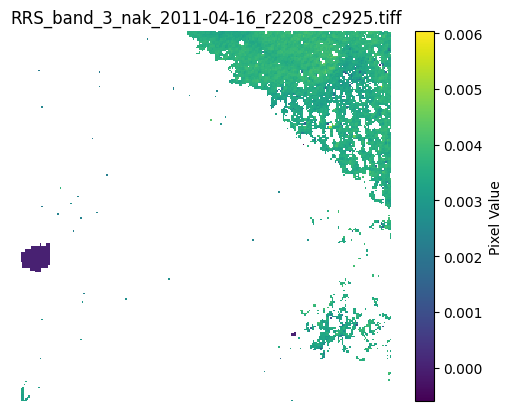

Loaded RRS_band_3_nak_2011-04-16_r2208_c2927.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-16_r2208_c2927.tiff 전체 NaN 값 비율: 86.28%
RRS_band_3_nak_2011-04-16_r2208_c2927.tiff 0 값 비율: 0.44%
RRS_band_3_nak_2011-04-16_r2208_c2927.tiff 유니크 값: [-0.00059825 -0.00016633  0.         ...  0.00497553  0.00575858
  0.0060341 ]


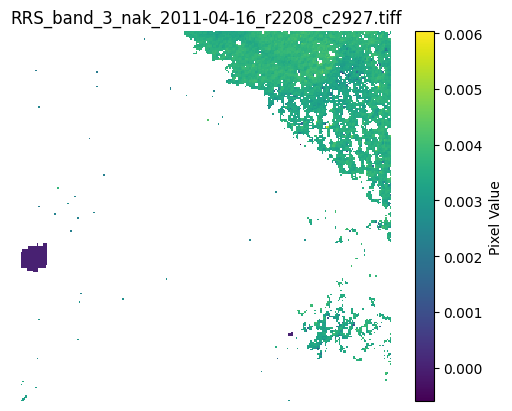

Loaded RRS_band_3_nak_2011-04-16_r2209_c2925.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-16_r2209_c2925.tiff 전체 NaN 값 비율: 86.81%
RRS_band_3_nak_2011-04-16_r2209_c2925.tiff 0 값 비율: 0.47%
RRS_band_3_nak_2011-04-16_r2209_c2925.tiff 유니크 값: [-0.00059825 -0.00016633  0.         ...  0.00497553  0.00575858
  0.0060341 ]


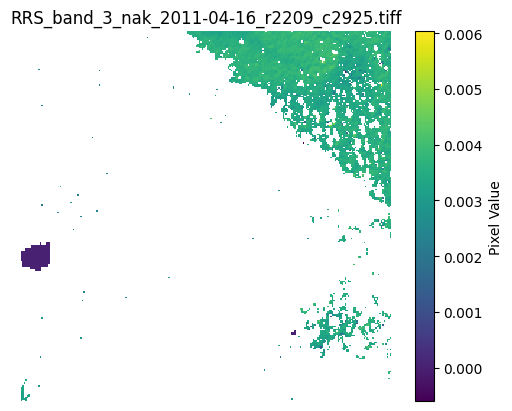

Loaded RRS_band_3_nak_2011-04-03_r2213_c3003.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-03_r2213_c3003.tiff 전체 NaN 값 비율: 88.99%
RRS_band_3_nak_2011-04-03_r2213_c3003.tiff 0 값 비율: 0.01%
RRS_band_3_nak_2011-04-03_r2213_c3003.tiff 유니크 값: [0.         0.00033373 0.00066237 ... 0.0052194  0.00532652 0.00610052]


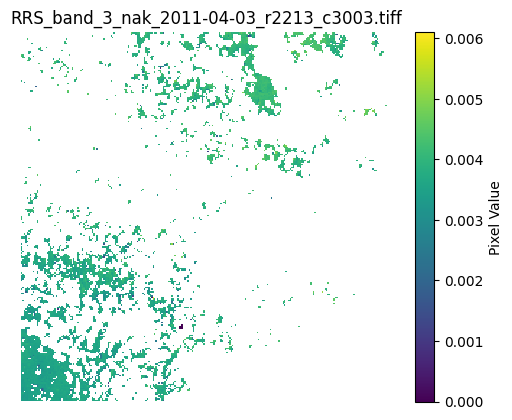

Loaded RRS_band_3_nak_2011-04-03_r2236_c2989.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-03_r2236_c2989.tiff 전체 NaN 값 비율: 85.91%
RRS_band_3_nak_2011-04-03_r2236_c2989.tiff 0 값 비율: 0.01%
RRS_band_3_nak_2011-04-03_r2236_c2989.tiff 유니크 값: [0.         0.00033373 0.00034909 ... 0.0052194  0.00532652 0.00610052]


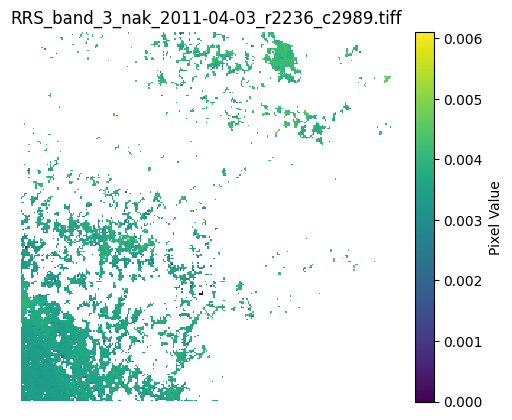

Loaded RRS_band_3_nak_2011-04-03_r2215_c2943.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-03_r2215_c2943.tiff 전체 NaN 값 비율: 80.35%
RRS_band_3_nak_2011-04-03_r2215_c2943.tiff 0 값 비율: 0.06%
RRS_band_3_nak_2011-04-03_r2215_c2943.tiff 유니크 값: [0.         0.00033373 0.00034909 ... 0.0052194  0.00532652 0.00610052]


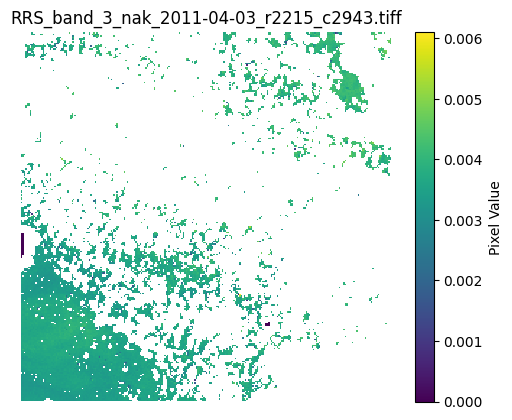

Loaded RRS_band_3_nak_2011-04-03_r2208_c3004.tiff with shape (256, 256) and dtype float32
RRS_band_3_nak_2011-04-03_r2208_c3004.tiff 전체 NaN 값 비율: 89.00%
RRS_band_3_nak_2011-04-03_r2208_c3004.tiff 0 값 비율: 0.01%
RRS_band_3_nak_2011-04-03_r2208_c3004.tiff 유니크 값: [0.         0.00033373 0.00066237 ... 0.0052194  0.00532652 0.00610052]


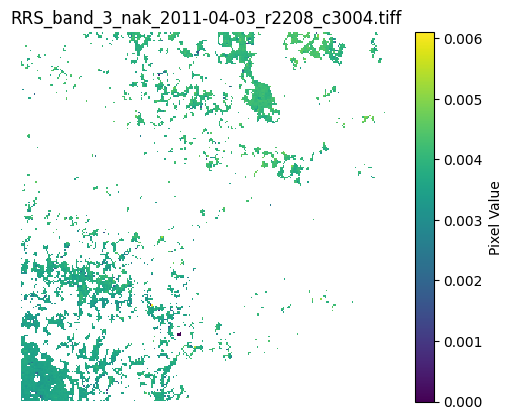

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff  # For reading TIFF files

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents/RRS_preprocessed"

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return viridis

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
for dirpath, dirnames, filenames in os.walk(root_directory):
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # tifffile을 사용하여 이미지 불러오기 (16비트 이미지로 읽기)
            img = tiff.imread(file_path)

            if img is None:
                print(f"{filename} could not be loaded.")
                continue
            
            print(f"Loaded {filename} with shape {img.shape} and dtype {img.dtype}")

            # NaN 값 비율 계산
            total_pixels = img.size
            nan_count = np.count_nonzero(np.isnan(img))
            nan_ratio = (nan_count / total_pixels) * 100

            # 0 값 비율 계산
            zero_count = np.count_nonzero(img == 0)
            zero_ratio = (zero_count / total_pixels) * 100

            # Unique 값 계산
            unique_values = np.unique(img[~np.isnan(img)])  # NaN은 제외하고 유니크 값 계산

            # 결과 출력
            print(f"{filename} 전체 NaN 값 비율: {nan_ratio:.2f}%")
            print(f"{filename} 0 값 비율: {zero_ratio:.2f}%")
            print(f"{filename} 유니크 값: {unique_values}")

            # 이미지 표시
            plt.imshow(img, cmap=custom_cmap, interpolation='none')
            plt.axis('off')  # 축 제거
            plt.colorbar(label='Pixel Value')  # 컬러맵 바 추가
            plt.title(f"{filename}")  # 파일명 출력

            plt.show()  # 각 이미지별로 별도 창으로 보여줌
